# Configure Environment

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)
#
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import RobustScaler
#
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


# Data Preparation

In [ ]:
# Data Preparation and Inspection

from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/AN2DL_HW_2/training_dataset.zip



Mounted at /content/drive
Archive:  /content/drive/MyDrive/AN2DL_HW_2/training_dataset.zip
  inflating: categories.npy          
  inflating: training_data.npy       
  inflating: valid_periods.npy       


In [ ]:
categories = np.load('categories.npy')
training_data = np.load('training_data.npy').astype(np.float32)
valid_periods = np.load('valid_periods.npy')

categories.shape , training_data.shape, valid_periods.shape

((48000,), (48000, 2776), (48000, 2))

In [ ]:
def Remove_Zero_Paddings(sequence, valid_period):
    compacted_sequences = []
    for idx, start_idx, end_idx in zip(range(len(sequence)), valid_period[:, 0], valid_period[:, 1]):
        compacted_sequences.append(sequence[idx][start_idx:end_idx])
    return np.array(compacted_sequences)

training_data = Remove_Zero_Paddings(training_data, valid_periods)
training_data.shape

(48000,)

In [ ]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Apply the RobustScaler to each time series independently
scaled_training_data = [scaler.fit_transform(series.reshape(-1, 1)).flatten() for series in training_data]


# Data Insight

In [ ]:
lenght_timeseries = valid_periods[:,1] - valid_periods[:,0]

np.sum(lenght_timeseries < 200)/lenght_timeseries.shape[0] , min(lenght_timeseries), max(lenght_timeseries)


(0.5196458333333334, 24, 2776)

In [ ]:
del lenght_timeseries

In [ ]:
categories = np.array(categories)
for cats in np.unique(categories):
  print(f"the category {cats} from {np.where(categories == cats)[0][0]} to {np.where(categories == cats)[0][-1]}")

the category A from 20991 to 26718
the category B from 36736 to 47722
the category C from 26719 to 36735
the category D from 0 to 10015
the category E from 10016 to 20990
the category F from 47723 to 47999


In [ ]:
for i in range (0 , 50):
  plot_acf(training_data[i],lags=len(training_data[i])-1 )
  plt.show()

In [ ]:
for i in range (50):
  plot_pacf(training_data[i],lags=len(training_data[i]) /2 -1  )
  plt.show()

In [ ]:
avg = []
for cats in np.unique(categories):
  ac = []
  i = np.where(categories == cats)[0][0]
  j = np.where(categories == cats)[0][-1]
  for k in range(i,j):
    temp = np.array(sm.tsa.acf(training_data[k], nlags = len(training_data[k])))
    ac.append(np.argmax(temp < 0.5))
    avg.append(np.argmax(temp < 0.5))

  print(f"the category {cats} ==> mean : {np.mean(ac) : .2f} , std : {np.std(ac) : .2f}")
print (f"the total avg is {np.mean( avg ): .2f} , and the total std is {np.std(avg): .2f}")

the category A ==> mean :  94.31 , std :  41.03
the category B ==> mean :  50.93 , std :  37.48
the category C ==> mean :  65.50 , std :  45.94
the category D ==> mean :  68.84 , std :  48.52
the category E ==> mean :  51.84 , std :  41.85
the category F ==> mean :  55.16 , std :  37.28
the total avg is  63.12 , and the total std is  45.28


# Generate Dataset

In [ ]:
all_x = []
all_y = []
all_cats = []

def Gen_dataset(data, category, window, stride, telescope):

  short = window + telescope - len(data)

  if (short > 0):
    temp_data = np.concatenate((np.zeros((short), dtype='float32'),data))
  else :
    temp_data = data


  padding_check = (len(temp_data) - window - telescope )  % stride

  if (padding_check !=0):

    padding_len = stride - padding_check
    padding = np.zeros((padding_len), dtype='float32')
    temp_data = np.concatenate((padding,temp_data))

  for idx in np.arange(0,len(temp_data)-window-telescope + 1,stride):

    all_x.append(temp_data[idx:idx+window])
    all_y.append(temp_data[idx+window:idx+window+telescope])
    all_cats.append(category)

  #return np.array(X), np.array(labels), np.array(cat)

In [ ]:
for i in range(len(training_data)):

  Gen_dataset(data=training_data[i], category = categories[i] , window= 200 , stride= 20, telescope=9)

all_x = np.array(all_x)[:, :, np.newaxis]
all_y = np.array(all_y)[:, :, np.newaxis]
all_cats = np.array(all_cats)

all_x.shape, all_y.shape, all_cats.shape




((172849, 200, 1), (172849, 9, 1), (172849,))

In [ ]:
def One_hot_encoding(category_array):
  unique_categories = np.unique(category_array)
  category_to_index = {category: index for index, category in enumerate(unique_categories)}

  # Convert string categories to integer labels
  integer_labels = np.array([category_to_index[category] for category in category_array])

  # Convert integer labels to one-hot encoded categorical variable
  return tf.keras.utils.to_categorical(integer_labels)
all_cats = One_hot_encoding(all_cats)
all_cats.shape


(172849, 6)

In [ ]:
def Integer_encoding(category_array):
  unique_categories = np.unique(category_array)
  category_to_index = {category: index for index, category in enumerate(unique_categories)}

  # Convert string categories to integer labels
  integer_labels = np.array([category_to_index[category] for category in category_array])

  # Convert integer labels to one-hot encoded categorical variable
  return integer_labels
all_cats_int = Integer_encoding(all_cats)[:,np.newaxis]
all_cats_int.shape

In [ ]:
del categories
del training_data
del valid_periods

# Some Models






In [ ]:
def Model_V_1(input_shape , output_shape, Cat_shape):

  input1 = tfkl.Input(shape = input_shape , name = 'input_time_series')
  input2 = tfkl.Input(shape = Cat_shape , name = 'domain_label_input')

  # Add a Bidirectional LSTM layer with 64 units
  x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input1)

  # Add a 1D Convolution layer with 128 filters and a kernel size of 3
  tmp = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')
  x = tmp(x)

  # Add a final Convolution layer to match the desired output shape
  x = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

  # Calculate the size to crop from the output to match the output shape
  # Crop the output to the desired length

  x = tfkl.Concatenate(axis = -2)([x, input2])

  x = tfkl.Dense(64, activation = 'sigmoid')(x)

  x = tfkl.Dense (1 , activation = 'sigmoid')(x)

  crop_size = x.shape[1] - output_shape[0]
  output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(x)


  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=[input1, input2] , outputs=output_layer, name='CONV_LSTM_model')

  # Compile the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

  return model


In [ ]:
def Model_V_2(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    tmp= tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')
    x= tmp(x) #Did this to solve this error "ValueError: tf.function-decorated function tried to create variables on non-first call"

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
def Model_V_3(input_shape , output_shape, Cat_shape):

  # Input layer for time series data
  input1 = Input(shape=input_shape, name='input_time_series')

  # Input layer for domain labels
  input2 = Input(shape=Cat_shape, name='input_domain_label')

  # Embedding layer for domain labels
  domain_embedding = Embedding(input_dim=6, output_dim=10, name='domain_embedding')(input2)
  domain_embedding = Flatten()(domain_embedding)

  # # Concatenate the time series data and domain embeddings
  # merged_input = Concatenate()([input_time_series, domain_embedding])



In [ ]:

all_x.shape, all_y.shape, all_cats_int.shape

((172849, 200, 1), (172849, 9, 1), (172849, 1))

# ResNet Models Development

In [ ]:
all_x.shape, all_y.shape, all_cats_int.shape

((172849, 200, 1), (172849, 9, 1), (172849, 1))

In [ ]:
def Resnet_Model_V_4(input_shape, output_shape):

  n_feature_maps = 64

  input_layer = tfkl.Input(input_shape)

  #input_categories = tfkl.Input(cat_shape)

  # embedding_layer = tfkl.Embedding(input_dim=6, output_dim=128, input_length=1)(input_categories)
  # flatten_layer = tfkl.Flatten()
  # embedding_layer = flatten_layer(embedding_layer)


  #mask = tfkl.Masking(mask_value=0.0)(input_layer)



  # BLOCK 1

  conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
  conv_x = tfkl.BatchNormalization()(conv_x)
  conv_x = tfkl.Activation('relu')(conv_x)

  conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
  conv_y = tfkl.BatchNormalization()(conv_y)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
  conv_z = tfkl.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_1 = tfkl.add([shortcut_y, conv_z])
  output_block_1 = tfkl.Activation('relu')(output_block_1)

  # BLOCK 2

  conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
  conv_x = tfkl.BatchNormalization()(conv_x)
  conv_x = tfkl.Activation('relu')(conv_x)

  conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = tfkl.BatchNormalization()(conv_y)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = tfkl.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_2 = tfkl.add([shortcut_y, conv_z])
  output_block_2 = tfkl.Activation('relu')(output_block_2)

  # BLOCK 3

  conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
  conv_x = tfkl.BatchNormalization()(conv_x)
  conv_x = tfkl.Activation('relu')(conv_x)

  conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = tfkl.BatchNormalization()(conv_y)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = tfkl.BatchNormalization()(conv_z)

  # no need to expand channels because they are equal
  shortcut_y = tfkl.BatchNormalization()(output_block_2)

  output_block_3 = tfkl.add([shortcut_y, conv_z])
  output_block_3 = tfkl.Activation('relu')(output_block_3)

  # FINAL

  gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

  #concated = tfkl.Concatenate()([gap_layer,embedding_layer])

  output_layer = tfkl.Dense(output_shape[0], activation='tanh')(gap_layer)

  model = tfk.models.Model(inputs=[input_layer], outputs=output_layer)

  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

  return model

In [ ]:
def residual_block(x, num_filters, num_blocks=2, kernel_size=3, activation='relu'):

  x_=x

  for i in range(num_blocks):
    x = tfkl.Conv1D(num_filters,kernel_size,padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    if i == num_blocks-1:
      x_ = tfkl.Conv1D(num_filters,1,padding='same')(x_)
      x = tfkl.Add()([x,x_])
      x = tfkl.Activation(activation=activation)(x)
    else:
      x = tfkl.Activation(activation=activation)(x)

  return x

def Resnet_V_2_Model_V_5(input_shape, output_shape, cat_shape):

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    #input_layer = tfkl.Masking(mask_value=0.0)(input_layer)

    input_categories = tfkl.Input(cat_shape)
    embedding_layer = tfkl.Embedding(input_dim=6, output_dim=128, input_length=1)(input_categories)
    flatten_layer = tfkl.Flatten()
    embedding_layer = flatten_layer(embedding_layer)


    x = tfkl.Conv1D(32,3,padding='same',activation='relu',name='conv_1')(input_layer)
    x = tfkl.MaxPool1D()(x)

    x = tfkl.Conv1D(3,1,padding='same',activation='relu',name='bottleneck_1')(x)
    x = residual_block(x,64)
    x = tfkl.MaxPool1D()(x)

    x = tfkl.Conv1D(3,1,padding='same',activation='relu',name='bottleneck_2')(x)
    x = residual_block(x,128)
    x = tfkl.MaxPool1D()(x)

    #3,6,12,24,30,60,66,132,138

    x = tfkl.Conv1D(3,1,padding='same',activation='relu',name='bottleneck_3')(x)
    x = residual_block(x,256)
    x = tfkl.MaxPool1D()(x)

    x = tfkl.Conv1D(3,1,padding='same',activation='relu',name='bottleneck_4')(x)
    x = residual_block(x,512)

    x = tfkl.GlobalAveragePooling1D()(x)

    concated = tfkl.Concatenate()([x,embedding_layer])

    output_layer = tfkl.Dense(units=output_shape[0],activation='sigmoid')(concated)

    model = tf.keras.Model(inputs=[input_layer,input_categories], outputs=output_layer, name='res_net_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    return model

In [ ]:
#model = Model_V_1(all_x.shape[1:], all_y.shape[1:], all_cats.shape[1:])
#model = Model_V_2(all_x.shape[1:], all_y.shape[1:])
model = Resnet_V_2_Model_V_5(all_x.shape[1:], all_y.shape[1:],all_cats_int.shape[1:])
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
history = model.fit(
    x = [all_x,all_cats_int],
    y = all_y,
    batch_size = 64,
    epochs = 150,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

# Attempt for Transformers

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the Transformer encoder layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)  # Self-attention
        out1 = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + out1)

        ffn_output = self.ffn(out1)
        out2 = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + out2)

        return out2

# Define the Transformer encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.embedding = layers.LSTM(d_model, return_sequences=True, input_shape=input_shape)

        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    def call(self, x, training):
        x = self.embedding(x)
        for layer in self.enc_layers:
            x = layer(x, training)

        return x

# Define the Transformer decoder layer
class TransformerDecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerDecoderLayer, self).__init__()

        self.mha1 = layers.MultiHeadAttention(num_heads, d_model)
        self.mha2 = layers.MultiHeadAttention(num_heads, d_model)

        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, x, enc_output, training):
        attn1 = self.mha1(x, x, x)  # Self-attention
        out1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + out1)

        attn2 = self.mha2(enc_output, enc_output, out1)  # Cross-attention
        out2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + out2)

        ffn_output = self.ffn(out2)
        out3 = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + out3)

        return out3

# Define the Transformer decoder
class TransformerDecoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_shape, rate=0.1):
        super(TransformerDecoder, self).__init__()

        self.embedding = layers.LSTM(d_model, return_sequences=True, input_shape=target_shape)

        self.dec_layers = [TransformerDecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training):
        x = self.embedding(x)
        for layer in self.dec_layers:
            x = layer(x, enc_output, training)

        return x

# Define the Transformer model
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, target_shape, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, input_shape, rate)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, dff, target_shape, rate)
        self.final_layer = layers.Dense(1)

    def call(self, inp, tar, training):
        enc_output = self.encoder(inp, training)
        dec_output = self.decoder(tar, enc_output, training)
        final_output = self.final_layer(dec_output)

        return final_output

####################################################################################

import tensorflow as tf
from sklearn.model_selection import train_test_split


# Split the data into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(all_x, all_y, test_size=0.1, random_state=42)

# Define the Transformer model
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
input_shape = (200, 1)
target_shape = (9, 1)

transformer = Transformer(num_layers, d_model, num_heads, dff, input_shape, target_shape)
inp = tf.zeros((1, 200, 1))
out =  tf.zeros((1, 9, 1))
transformer(inp, out)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.MeanSquaredError()
transformer.compile(optimizer=optimizer, loss=loss_object)
xtransformer.summary()
tfk.utils.plot_model(transformer, expand_nested=True, show_shapes=True)


# # Train the model with teacher forcing
# for epoch in range(epochs):
#     for batch in range(num_batches):
#         with tf.GradientTape() as tape:
#             predictions = transformer(X_train_batch, training=True)
#             loss = loss_object(Y_train_batch, predictions)

#         gradients = tape.gradient(loss, transformer.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))



In [ ]:
# Save the trained model
transformer.save('transformer_model')

# Load the trained model
loaded_model = tf.keras.models.load_model('transformer_model')

# Perform inference without teacher forcing
# Initialize the first input for the inference
current_input = initial_input  # Replace with the appropriate initial input

# Generate the output sequence one step at a time
for _ in range(output_length):
    # Make a prediction using the current input
    prediction = loaded_model.predict(current_input)

    # Update the input for the next time step
    current_input = update_input(current_input, prediction)
##########################################################################################################

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming you have X_train and Y_train
X_train = ...  # Your input data with shape (123456, 200, 1)
Y_train = ...  # Your target data with shape (123456, 9, 1)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Define the Transformer model
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
input_shape = (200, 1)
target_shape = (9, 1)

transformer = Transformer(num_layers, d_model, num_heads, dff, input_shape, target_shape)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.MeanSquaredError()
transformer.compile(optimizer=optimizer, loss=loss_object)

# Train the model
transformer.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_val, Y_val))

# Save the trained model
transformer.save('transformer_model')

# Load the trained model
loaded_model = tf.keras.models.load_model('transformer_model')

# Perform inference
# Assuming you have X_test with shape (num_samples, 200, 1)
X_test = ...
predictions = loaded_model.predict(X_test)

# predictions now contains the forecasted values for each sequence in X_test


# Encoder Decoder Attention Models

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Attention,Add, Concatenate,GlobalAveragePooling1D,LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model


def encoder(input_shape, output_shape, num_heads, lattent_dims):
    #Encoder
    encoder_input = Input(shape=input_shape, name='encoder_input')

    #LSTM layer in the encoder
    encoder_lstm = LSTM(units=lattent_dims, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_embs, enc_state_c, enc_state_h = encoder_lstm(encoder_input)

    #Query, Key, and Value in Self-Attention of the encoder
    value_encoder = Dense(lattent_dims, activation = 'linear')
    projected_value_encoder = value_encoder(encoder_embs)

    query_encoder = Dense(lattent_dims, activation = 'linear')
    projected_query_encoder = query_encoder(encoder_embs)

    #Self-Attention Mechanism in the encoder
    encoder_self_att = MultiHeadAttention(num_heads = num_heads)([projected_query_encoder, projected_value_encoder])
    #encoder_self_att = GlobalAveragePooling1D()(encoder_self_att)

    #Addition and Layer Normalization First
    addition_attention_residual = Add()([encoder_embs,encoder_self_att])
    first_normalization_encoder = LayerNormalization()(addition_attention_residual)
    #FFN encoder
    feed_forward_encoder = Dense(lattent_dims, activation='linear')
    encoder_enriched = feed_forward_encoder(first_normalization_encoder)

    #Addition and Layer Normalization Second
    addition_second_encoder = Add()([first_normalization_encoder,encoder_enriched])
    encoder_output = LayerNormalization()(addition_second_encoder)

    encoder_model = Model(inputs = encoder_input , outputs = encoder_output, name = "ENCODER")

    return encoder_model , enc_state_h, enc_state_c

def decoder(input_shapes, output_shape, num_heads, lattent_dims, enc_state_h, enc_state_c):

    decoder_input_1 = Input(shape= input_shaps[0], name='decoder_input_sequence')
    decoder_input_2 = Input(shape = input_shapes[1], name = 'decoder_input_source_context')

    #LSTM layer in the decoder
    decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_embs, _, _ = decoder_lstm(decoder_input, initial_state=[enc_state_h, enc_state_c])

    #Query, Key, and Value in Self-Attention of the decoder
    value_decoder = Dense(hidden_dim, activation = 'linear')
    projected_value_decoder = value_decoder(decoder_embs)

    query_decoder = Dense(hidden_dim, activation = 'linear')
    projected_query_decoder = query_decoder(decoder_embs)

    #Self-Attention Mechanism in the decoder
    decoder_self_att = MultiHeadAttention(num_heads= num_heads)([projected_query_decoder, projected_value_decoder], use_causal_mask = True)
    #decoder_self_att = GlobalAveragePooling1D()(decoder_self_att)

    #Addition and Layer Normalization First
    first_addition_decoder = Add()([decoder_embs,decoder_self_att])
    first_normalization_decoder = LayerNormalization()(first_addition_decoder)



    #Preparing the query, key, and Value for the cross attention mechanism in decoder
    query_cross_att = Dense(hidden_dim, activation= 'linear')
    projected_query_cross = query_cross_att(first_normalization_decoder)

    value_cross_att = Dense(hidden_dim, activation = 'linear')
    projected_value_cross = value_cross_att(decoder_input_2)

    # Cross-Attention Mechanism
    cross_att = MultiHeadAttention(num_heads = num_heads)([projected_query_cross, projected_value_cross])
    ################decoder_attended_context = Concatenate(axis=-1)([decoder_output, cross_att])
    #cross_att = GlobalAveragePooling1D()(cross_att)

    #Addition and Layer Normalization Second
    second_addition_decoder = Add()([cross_att, first_normalization_decoder])
    second_normalization_decoder = LayerNormalization()(second_addition_decoder)

    #FFN decoder
    ffn_decoder = Dense(hidden_dim, activation = 'linear')
    enriched_decoder = ffn_decoder(second_normalization_decoder)

    #Addition and Layer Normalization third
    third_addition_decoder = Add()([enriched_decoder, second_normalization_decoder])
    decoder_output = LayerNormalization()(third_addition_decoder)

    # Dense Output
    dense_out = Dense(1, activation='sigmoid', name='dense_out')
    final_output = dense_out(decoder_output)

    model = Model([decoder_input_1, decoder_input_2], final_output, name='DECODER')

    return model


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Attention,Add, Concatenate,GlobalAveragePooling1D,LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

def build_encoder_decoder_attention_model(input_shape, output_shape):
    hidden_dim  = 256
    #Encoder
    encoder_input = Input(shape=input_shape, name='encoder_input')

    #LSTM layer in the encoder
    encoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_embs, enc_state_c, enc_state_h = encoder_lstm(encoder_input)

    #Query, Key, and Value in Self-Attention of the encoder
    value_encoder = Dense(hidden_dim, activation = 'linear')
    projected_value_encoder = value_encoder(encoder_embs)

    query_encoder = Dense(hidden_dim, activation = 'linear')
    projected_query_encoder = query_encoder(encoder_embs)

    key_encoder = Dense(hidden_dim, activation = 'linear')
    projected_key_encoder = key_encoder(encoder_embs)

    #Self-Attention Mechanism in the encoder
    encoder_self_att = Attention()( [projected_query_encoder, projected_key_encoder, projected_value_encoder])
    #encoder_self_att = GlobalAveragePooling1D()(encoder_self_att)

    #Addition and Layer Normalization First
    addition_attention_residual = Add()([encoder_embs,encoder_self_att])
    first_normalization_encoder = LayerNormalization()(addition_attention_residual)
    #FFN encoder
    feed_forward_encoder = Dense(hidden_dim, activation='linear')
    encoder_enriched = feed_forward_encoder(first_normalization_encoder)

    #Addition and Layer Normalization Second
    addition_second_encoder = Add()([first_normalization_encoder,encoder_enriched])
    encoder_output = LayerNormalization()(addition_second_encoder)
    #################
    ##### Decoder####
    #################
    decoder_input = Input(shape= output_shape, name='decoder_input')

    #LSTM layer in the decoder
    decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_embs, _, _ = decoder_lstm(decoder_input, initial_state=[enc_state_h, enc_state_c])

    #Query, Key, and Value in Self-Attention of the decoder
    value_decoder = Dense(hidden_dim, activation = 'linear')
    projected_value_decoder = value_decoder(decoder_embs)

    query_decoder = Dense(hidden_dim, activation = 'linear')
    projected_query_decoder = query_decoder(decoder_embs)

    key_decoder = Dense(hidden_dim, activation = 'linear')
    projected_key_decoder = key_decoder(decoder_embs)

    #Self-Attention Mechanism in the decoder
    decoder_self_att = Attention()([projected_query_decoder, projected_key_decoder , projected_value_decoder])
    #decoder_self_att = GlobalAveragePooling1D()(decoder_self_att)

    #Addition and Layer Normalization First
    first_addition_decoder = Add()([decoder_embs,decoder_self_att])
    first_normalization_decoder = LayerNormalization()(first_addition_decoder)

    #Preparing the query, key, and Value for the cross attention mechanism in decoder
    query_cross_att = Dense(hidden_dim, activation= 'linear')
    projected_query_cross = query_cross_att(first_normalization_decoder)

    value_cross_att = Dense(hidden_dim, activation = 'linear')
    projected_value_cross = value_cross_att(encoder_output)

    key_cross_att = Dense(hidden_dim, activation = 'linear')
    projected_key_cross = key_cross_att(encoder_output)

    # Cross-Attention Mechanism
    cross_att = Attention()([projected_query_cross,  projected_key_cross, projected_value_cross])
    ################decoder_attended_context = Concatenate(axis=-1)([decoder_output, cross_att])
    #cross_att = GlobalAveragePooling1D()(cross_att)

    #Addition and Layer Normalization Second
    second_addition_decoder = Add()([cross_att, first_normalization_decoder])
    second_normalization_decoder = LayerNormalization()(second_addition_decoder)

    #FFN decoder
    ffn_decoder = Dense(hidden_dim, activation = 'linear')
    enriched_decoder = ffn_decoder(second_normalization_decoder)

    #Addition and Layer Normalization third
    third_addition_decoder = Add()([enriched_decoder, second_normalization_decoder])
    decoder_output = LayerNormalization()(third_addition_decoder)

    # Dense Output
    dense_out = Dense(1, activation='sigmoid', name='dense_out')
    final_output = dense_out(decoder_output)

    # Model
    model = Model([encoder_input, decoder_input], final_output, name='encoder_decoder_attention_model')

    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='MSE')
    return model


Model: "encoder_attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 200, 1)]             0         []                            
                                                                                                  
 encoder_lstm (LSTM)         [(None, 200, 64),            16896     ['encoder_input[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 dense_124 (Dense)           (None, 200, 64)              4160      ['encoder_lstm[0][0]']        
                                                                            

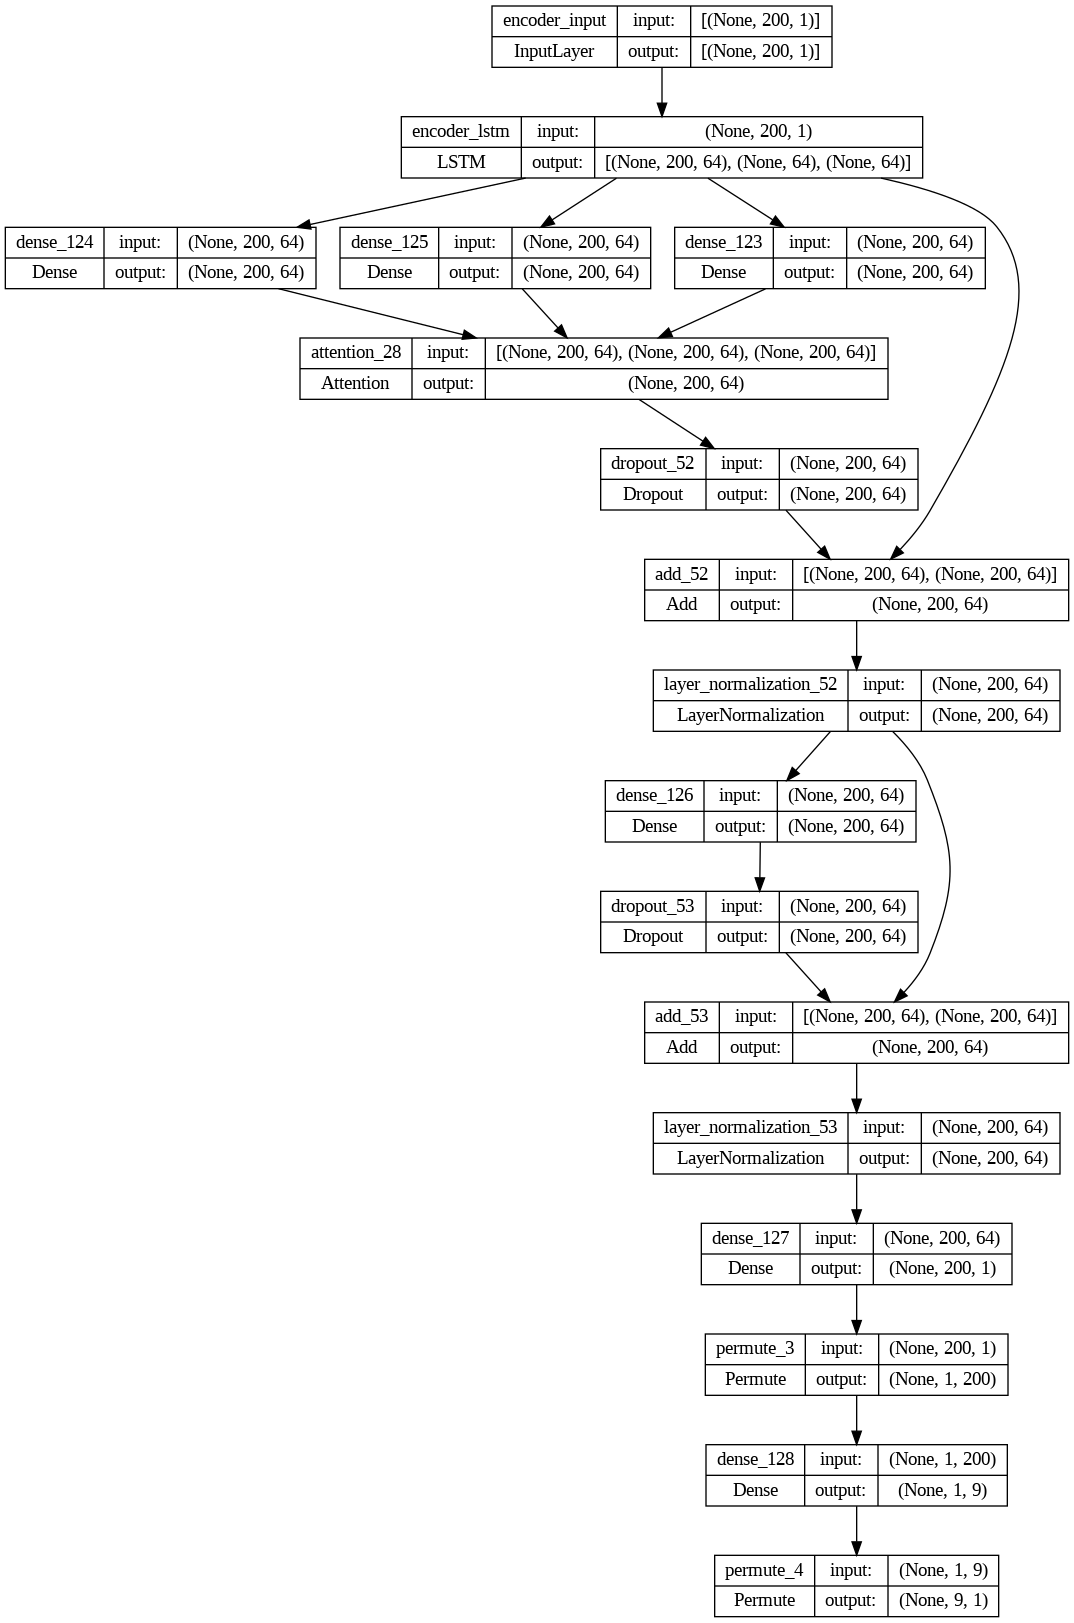

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Add, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Dropout,Conv1D,Permute
from tensorflow.keras.models import Model

def Encoder_Attention(input_shape, dropout_rate=0.3):
    hidden_dim = 64

    #################
    ##### Encoder####
    #################

    encoder_input = Input(shape=input_shape, name='encoder_input')
    encoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_embs, enc_state_c, enc_state_h = encoder_lstm(encoder_input)

    value_encoder = Dense(hidden_dim, activation='linear')
    projected_value_encoder = value_encoder(encoder_embs)

    query_encoder = Dense(hidden_dim, activation='linear')
    projected_query_encoder = query_encoder(encoder_embs)

    key_encoder = Dense(hidden_dim, activation='linear')
    projected_key_encoder = key_encoder(encoder_embs)

    encoder_self_att = Attention()([projected_query_encoder, projected_key_encoder, projected_value_encoder])
    encoder_self_att = Dropout(rate=dropout_rate)(encoder_self_att, training=True)  # Dropout during training only
    addition_attention_residual = Add()([encoder_embs, encoder_self_att])
    first_normalization_encoder = LayerNormalization()(addition_attention_residual)

    feed_forward_encoder = Dense(hidden_dim, activation='linear')
    encoder_enriched = feed_forward_encoder(first_normalization_encoder)
    encoder_enriched = Dropout(rate=dropout_rate)(encoder_enriched, training=True)  # Dropout during training only

    addition_second_encoder = Add()([first_normalization_encoder, encoder_enriched])
    encoder_output = LayerNormalization()(addition_second_encoder)
    encoder_output  = Dense(1, activation = 'linear')(encoder_output)

    output = Permute((2,1))(encoder_output)
    output = Dense(9, activation = 'sigmoid')(output)
    output = Permute((2,1))(output)



    model = Model(inputs = encoder_input, outputs =  output, name='encoder_attention_model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='MSE')

    return model


# Build the model
input_shape = all_x.shape[1:]

model = Encoder_Attention(input_shape)

# Compile the model

model.summary()
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(all_x, all_y, test_size=0.1, random_state=42)


In [ ]:
X_train.shape , Y_train.shape

((155564, 200, 1), (155564, 9, 1))

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=128,
    epochs=150,
    validation_split=.2,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, min_delta=0.0001),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history


Epoch 1/150
973/973 [==============================] - 30s 25ms/step - loss: 0.0198 - val_loss: 0.0116 - lr: 0.0010
Epoch 2/150
973/973 [==============================] - 24s 25ms/step - loss: 0.0108 - val_loss: 0.0100 - lr: 0.0010
Epoch 3/150
973/973 [==============================] - 25s 26ms/step - loss: 0.0101 - val_loss: 0.0097 - lr: 0.0010
Epoch 4/150
973/973 [==============================] - 24s 25ms/step - loss: 0.0098 - val_loss: 0.0096 - lr: 0.0010
Epoch 5/150
973/973 [==============================] - 24s 25ms/step - loss: 0.0096 - val_loss: 0.0096 - lr: 0.0010
Epoch 6/150
973/973 [==============================] - 24s 24ms/step - loss: 0.0095 - val_loss: 0.0091 - lr: 0.0010
Epoch 7/150
973/973 [==============================] - 24s 25ms/step - loss: 0.0094 - val_loss: 0.0099 - lr: 0.0010
Epoch 8/150
973/973 [==============================] - 24s 25ms/step - loss: 0.0092 - val_loss: 0.0089 - lr: 0.0010
Epoch 9/150
973/973 [==============================] - 24s 24ms/step - l

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Add, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def build_encoder_decoder_attention_model_V_2(input_shape, output_shape, dropout_rate=0.3):
    hidden_dim = 128

    #################
    ##### Encoder####
    #################

    encoder_input = Input(shape=input_shape, name='encoder_input')
    encoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_embs, enc_state_c, enc_state_h = encoder_lstm(encoder_input)

    value_encoder = Dense(hidden_dim, activation='linear')
    projected_value_encoder = value_encoder(encoder_embs)

    query_encoder = Dense(hidden_dim, activation='linear')
    projected_query_encoder = query_encoder(encoder_embs)

    key_encoder = Dense(hidden_dim, activation='linear')
    projected_key_encoder = key_encoder(encoder_embs)

    encoder_self_att = Attention()([projected_query_encoder, projected_key_encoder, projected_value_encoder])
    encoder_self_att = Dropout(rate=dropout_rate)(encoder_self_att, training=True)  # Dropout during training only
    addition_attention_residual = Add()([encoder_embs, encoder_self_att])
    first_normalization_encoder = LayerNormalization()(addition_attention_residual)

    feed_forward_encoder = Dense(hidden_dim, activation='linear')
    encoder_enriched = feed_forward_encoder(first_normalization_encoder)
    encoder_enriched = Dropout(rate=dropout_rate)(encoder_enriched, training=True)  # Dropout during training only

    addition_second_encoder = Add()([first_normalization_encoder, encoder_enriched])
    encoder_output = LayerNormalization()(addition_second_encoder)

    #################
    ##### Decoder####
    #################

    decoder_input = Input(shape=output_shape, name='decoder_input')
    decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_embs, _, _ = decoder_lstm(decoder_input, initial_state=[enc_state_h, enc_state_c])

    value_decoder = Dense(hidden_dim, activation='linear')
    projected_value_decoder = value_decoder(decoder_embs)

    query_decoder = Dense(hidden_dim, activation='linear')
    projected_query_decoder = query_decoder(decoder_embs)

    key_decoder = Dense(hidden_dim, activation='linear')
    projected_key_decoder = key_decoder(decoder_embs)

    decoder_self_att = Attention()([projected_query_decoder, projected_key_decoder, projected_value_decoder])
    decoder_self_att = Dropout(rate=dropout_rate)(decoder_self_att, training=True)  # Dropout during training only
    first_addition_decoder = Add()([decoder_embs, decoder_self_att])
    first_normalization_decoder = LayerNormalization()(first_addition_decoder)

    query_cross_att = Dense(hidden_dim, activation='linear')
    projected_query_cross = query_cross_att(first_normalization_decoder)

    value_cross_att = Dense(hidden_dim, activation='linear')
    projected_value_cross = value_cross_att(encoder_output)

    key_cross_att = Dense(hidden_dim, activation='linear')
    projected_key_cross = key_cross_att(encoder_output)

    cross_att = Attention()([projected_query_cross, projected_key_cross, projected_value_cross])
    decoder_attended_context = Add()([decoder_embs, cross_att])
    decoder_attended_context = Dropout(rate=dropout_rate)(decoder_attended_context, training=True)  # Dropout during training only

    second_normalization_decoder = LayerNormalization()(decoder_attended_context)

    ffn_decoder = Dense(hidden_dim, activation='linear')
    enriched_decoder = ffn_decoder(second_normalization_decoder)
    enriched_decoder = Dropout(rate=dropout_rate)(enriched_decoder, training=True)  # Dropout during training only

    third_addition_decoder = Add()([enriched_decoder, second_normalization_decoder])
    decoder_output = LayerNormalization()(third_addition_decoder)

    dense_out = Dense(1, activation='sigmoid', name='dense_out')
    final_output = dense_out(decoder_output)

    model = Model([encoder_input, decoder_input], final_output, name='encoder_decoder_attention_model')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='MSE')

    return model


# Build the model
input_shape = all_x.shape[1:]
output_shape = all_y.shape[1:]
model = build_encoder_decoder_attention_model_V_2(input_shape, output_shape)

# Compile the model

model.summary()
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)



In [ ]:
#!pip install tsaug
import tsaug


my_augmenter = (
                tsaug.TimeWarp() # random time warping

                + tsaug.Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                + tsaug.Drift(max_drift=(0.1, 0.3)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
                + tsaug.Reverse() @ 0.5  # with 50% probability, reverse the sequence
                )

X_aug = X_train
Y_aug = Y_train

for i in range(2):

  X_aug  = my_augmenter.augment(X_aug)
  Y_aug = my_augmenter.augment(Y_aug)
  X_train = np.concatenate([X_train,X_aug], axis = 0)
  Y_train = np.concatenate([Y_train , Y_aug], axis = 0)


X_train.shape , Y_train.shape




((466692, 200, 1), (466692, 9, 1))

In [ ]:
import numpy as np

# Assuming your tensor is named 'tensor_data' with shape (1234, 200, 1)

# Flatten the tensor to 1D
flat_data = Y_train.flatten()

# Calculate the percentage of values above 1
percentage_above_1 = np.sum(flat_data > 1) / flat_data.size * 100

# Calculate the percentage of values less than -1
percentage_below_minus_1 = np.sum(flat_data < -1) / flat_data.size * 100

# Calculate the percentage of values equal to or below zero
percentage_zero_or_below = np.sum(flat_data == 0) / flat_data.size * 100

print(f"Percentage of values above 1: {percentage_above_1:.2f}%")
print(f"Percentage of values below -1: {percentage_below_minus_1:.2f}%")
print(f"Percentage of values equal to or below zero: {percentage_zero_or_below:.2f}%")


Percentage of values above 1: 0.22%
Percentage of values below -1: 0.00%
Percentage of values equal to or below zero: 0.10%


In [ ]:
flat_data[flat_data  > 1]

array([1.0293244, 1.068515 , 1.0221237, ..., 1.0303854, 1.0133945,
       1.0023828], dtype=float32)

In [ ]:
first_elements = X_train[:, -1, 0].reshape(X_train.shape[0], 1, 1)
remaining_elements = Y_train[:, :-1, 0].reshape(Y_train.shape[0], Y_train.shape[1] - 1, 1)
y_train_dec_in = np.concatenate((first_elements, remaining_elements), axis=1)


In [ ]:
y_train_dec_in = np.random.rand(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2])
y_train_dec_in.shape , Y_train.shape , X_train.shape

((466692, 9, 1), (466692, 9, 1), (466692, 200, 1))

In [ ]:
history = model.fit(
    x=[X_train, y_train_dec_in],
    y=Y_train,
    batch_size=256,
    epochs=150,
    validation_split=.2,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, min_delta=0.0001),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history


Epoch 1/150
1459/1459 [==============================] - 112s 69ms/step - loss: 0.0370 - val_loss: 0.0403 - lr: 0.0010
Epoch 2/150
1459/1459 [==============================] - 98s 67ms/step - loss: 0.0320 - val_loss: 0.0391 - lr: 0.0010
Epoch 3/150
1459/1459 [==============================] - 99s 68ms/step - loss: 0.0311 - val_loss: 0.0374 - lr: 0.0010
Epoch 4/150
1459/1459 [==============================] - 97s 66ms/step - loss: 0.0305 - val_loss: 0.0376 - lr: 0.0010
Epoch 5/150
1459/1459 [==============================] - 105s 72ms/step - loss: 0.0301 - val_loss: 0.0376 - lr: 0.0010
Epoch 6/150
1459/1459 [==============================] - 111s 76ms/step - loss: 0.0301 - val_loss: 0.0379 - lr: 0.0010
Epoch 7/150
 809/1459 [===============>..............] - ETA: 41s - loss: 0.0308

KeyboardInterrupt: ignored

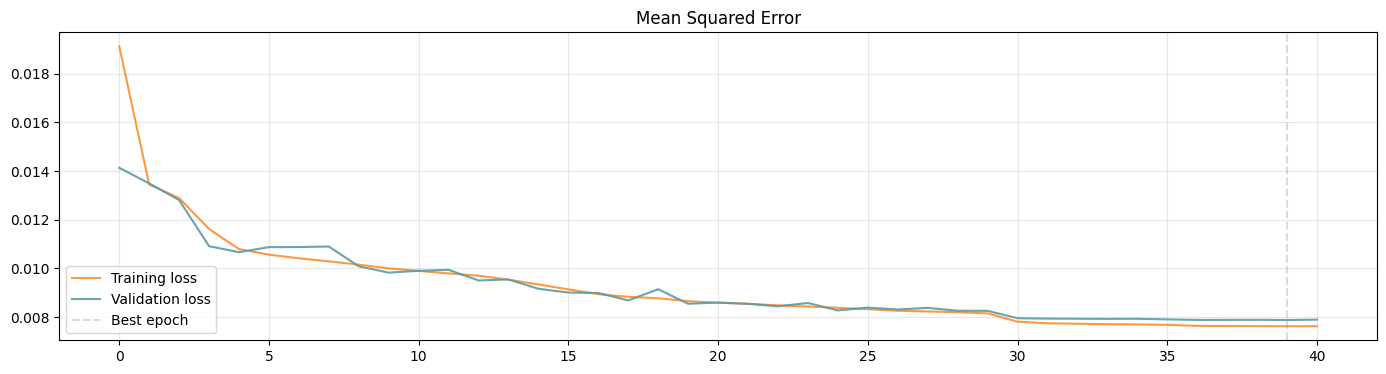

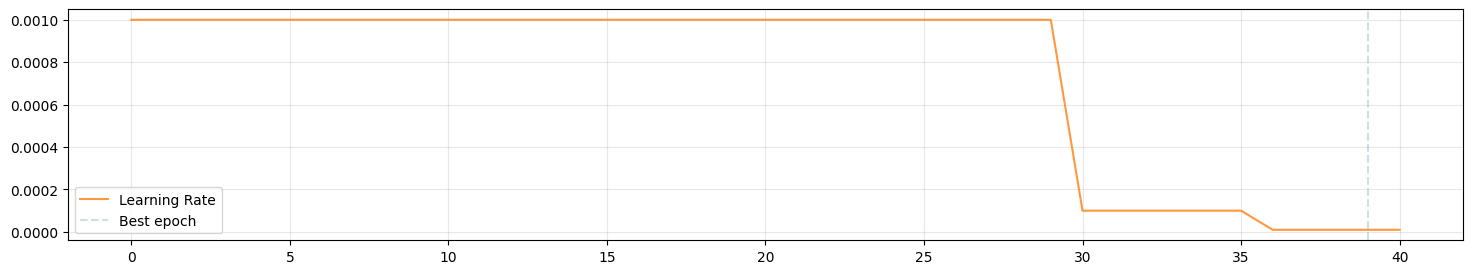

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
Y_hat = model.predict(X_test )

541/541 [==============================] - 8s 13ms/step


In [ ]:
decoded_sequences = []
for i in range(60):

    #print('----------')
    #print('Decoding sequence: ', i)

    predictions=[]

    initial_window = X_test[i]

    long_seq = initial_window
    long_seq = np.expand_dims(long_seq,axis=0)

    fake_seq = (X_test[i,-1][0])*np.ones((1,1), dtype='float32')
    zeros = np.zeros((8,1))
    fake_seq = np.concatenate([fake_seq,zeros],axis=0)
    fake_seq = np.expand_dims(fake_seq,axis=0)
    #print(f"{fake_seq.shape} , {long_seq.shape}" , )


    for j in range(9):
        preds = model.predict([long_seq,fake_seq], verbose=0)
        curr_value = preds[0][0]

        #print('curr_value shape prima: ', curr_value.shape)
        curr_value = np.expand_dims(curr_value,axis=0)
        #print('curr_value shape dopo: ', curr_value.shape)

        #initial_window.append(curr_value)
        initial_window = np.concatenate([initial_window,curr_value],axis=0)
        predictions.append(curr_value)
        #print('inizial window dopo: ', initial_window.shape)

        long_seq = initial_window[1+j:]
        long_seq = np.expand_dims(long_seq,axis=0)

        #fake_seq = (curr_value)*np.ones((1,1), dtype='float32')
        fake_seq = curr_value
        zeros = np.zeros((8,1))
        fake_seq = np.concatenate([fake_seq,zeros],axis=0)
        fake_seq = np.expand_dims(fake_seq,axis=0)
        #print(long_seq.shape)
        #print(fake_seq.shape)

    decoded_sequences.append(predictions)

In [ ]:
decoded_sequences = np.array(decoded_sequences)
decoded_sequences = np.squeeze(decoded_sequences , axis = -1)
decoded_sequences = np.squeeze(decoded_sequences , axis = -1)
decoded_sequences.shape

In [ ]:
Y_hat.shape, Y_test.shape

((17285, 9, 1), (17285, 9, 1))

In [ ]:
loss = tfk.losses.MeanSquaredError()
mse = loss(Y_test,Y_hat)
print(mse)

tf.Tensor(0.008199098, shape=(), dtype=float32)


In [ ]:
del model

In [ ]:
model.save('/content/drive/MyDrive/AN2DL_HW_2/Transformer(7.8e-4)')